# Models: Neural Network Matrix Factorization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../lib')

import numpy as np
import pandas as pd
from bunch import Bunch

import torch
from torch.utils.data import DataLoader, Subset
from torch.optim import SparseAdam, Adam
from sklearn.metrics import roc_auc_score

import pytorch_common.util as pu
from pytorch_common.modules.fn import Fn
from pytorch_common.callbacks import EarlyStop, \
                                     ReduceLROnPlateau, \
                                     Validation, \
                                     SaveBestModel
from pytorch_common.callbacks.output import Logger, \
                                            MetricsPlotter

from pytorch_common.util import set_device_name, \
                                get_device, \
                                LoggerBuilder

import model as ml
import data.dataset as ds

import metric as mt
import metric.discretizer as dr

import data.plot as pl
import data as dt

import logging
import random

from torchviz import make_dot

<Figure size 432x288 with 0 Axes>

## Setup

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [4]:
pu.set_device_name('gpu')

In [5]:
pu.get_device()

device(type='cuda', index=0)

In [6]:
cpu = torch.device("cpu")

In [7]:
torch.cuda.is_available()

True

In [8]:
torch.__version__

'1.11.0'

In [9]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

In [10]:
set_seed(42)

## Carga de dataset

In [11]:
def to_tensor(obs, device, columns): 
    data = obs[columns]
    if type(data) == pd.DataFrame:
        data = data.values
    return torch.tensor(data).to(device)

features_fn = lambda obs, device: to_tensor(obs, device, ['user_seq', 'movie_seq'])
target_fn   = lambda obs, device: to_tensor(obs, device, ['user_movie_rating'])

dataset = ds.MovieLensTMDBDatasetFactory.from_path(
    transform        = features_fn,
    target_transform = target_fn,
    device           = cpu,
    filter_fn        = lambda df: df[(df['user_movie_rating_year'] >= 2005) & (df['user_movie_rating_year'] <= 2019)]
)
dataset.info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191540 entries, 0 to 191539
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   user_id                      191540 non-null  int64         
 1   user_seq                     191540 non-null  int64         
 2   user_movie_tags              191540 non-null  object        
 3   user_movie_rating            191540 non-null  int64         
 4   user_movie_rating_timestamp  191540 non-null  datetime64[ns]
 5   user_movie_rating_year       191540 non-null  int64         
 6   movie_id                     191540 non-null  int64         
 7   movie_seq                    191540 non-null  int64         
 8   movie_title                  191540 non-null  string        
 9   movie_genres                 191540 non-null  object        
 10  movie_for_adults             191540 non-null  bool          
 11  movie_original_language   

In [12]:
train_set, eval_set = dataset.split_train_eval(split_year=2018)

2022-07-25 12:50:49,321 - INFO - Train: 83.74 % - Test: 7.71 %


## Definicion del modelo

In [13]:
params = Bunch({
    'lr': 0.001,
    'lr_factor': 0.1,
    'lr_patience': 8,
    'epochs': 50,
    'embedding_size': 50,
    'units_per_layer': [50, 10],
    'dropout': 0.2,
    'n_workers': 24,
    'batch_size': 512,
    'features_n_values': [len(it) for it in dataset.features_uniques],
    'device': get_device()
})

In [14]:
train_dl = DataLoader(train_set, params.batch_size, num_workers=params.n_workers, pin_memory=True)
test_dl  = DataLoader(eval_set,  params.batch_size, num_workers=params.n_workers, pin_memory=True)

In [15]:
model = ml.NNMF(
    params.features_n_values,
    params.embedding_size,
    params.units_per_layer,
    params.dropout
).to(params.device)
model
# make_dot(y_pred, params=dict(model.named_parameters()))

NNMF(
  (embedding): MultiFeatureEmbedding(
    (embedding): Embedding(31503, 50)
  )
  (mlp): MultiLayerPerceptron(
    (mlp): Sequential(
      (0): Linear(in_features=100, out_features=50, bias=True)
      (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=50, out_features=10, bias=True)
      (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (act): ReLU()
)

## Entrenamiento del modelo

<Figure size 1440x360 with 1 Axes>

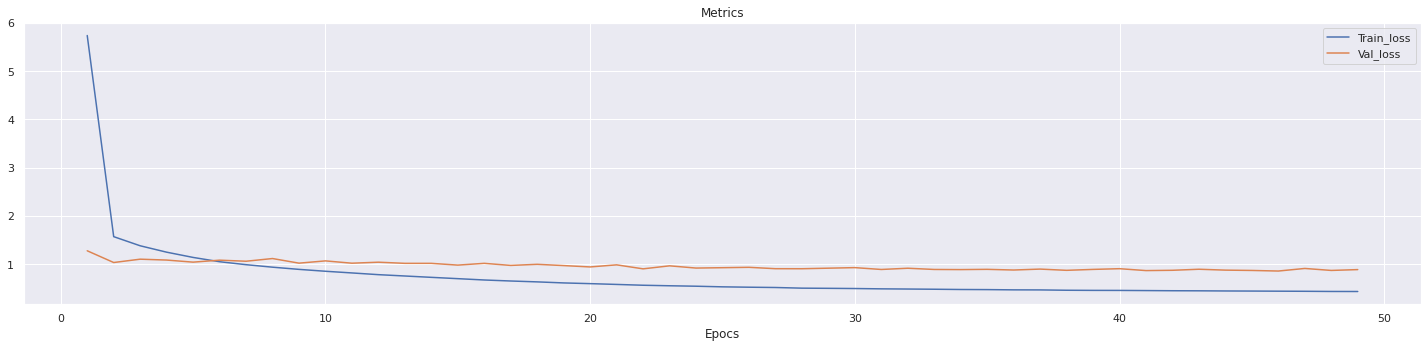

2022-07-23 17:00:01,361 - INFO - {'time': '0:00:08.71', 'epoch': 50, 'train_loss': 0.43166771554833006, 'val_loss': 0.8787339925765991, 'lr': 0.001}


In [21]:
result = model.fit(
    train_dl,
    epochs      = params.epochs,
    loss_fn     = ml.MSELossFn(),
    optimizer   = Adam(
        params       = model.parameters(),
        lr           = params.lr
    ),
    callbacks   = [
        Validation(
            test_dl,
            metrics = { 'val_loss': ml.MSELossFn(float_result=True)},
            each_n_epochs=1
        ),
        ReduceLROnPlateau(metric='val_loss', mode='min', factor=params.lr_factor, patience=params.lr_patience),
        MetricsPlotter(metrics=['train_loss', 'val_loss'], plot_each_n_epochs=2),
        Logger(['time', 'epoch', 'train_loss', 'val_loss', 'patience', 'lr']),
        SaveBestModel(metric='val_loss', path='../weights', experiment_name='nnmf')
    ]
)

Processing:   0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 1440x360 with 2 Axes>

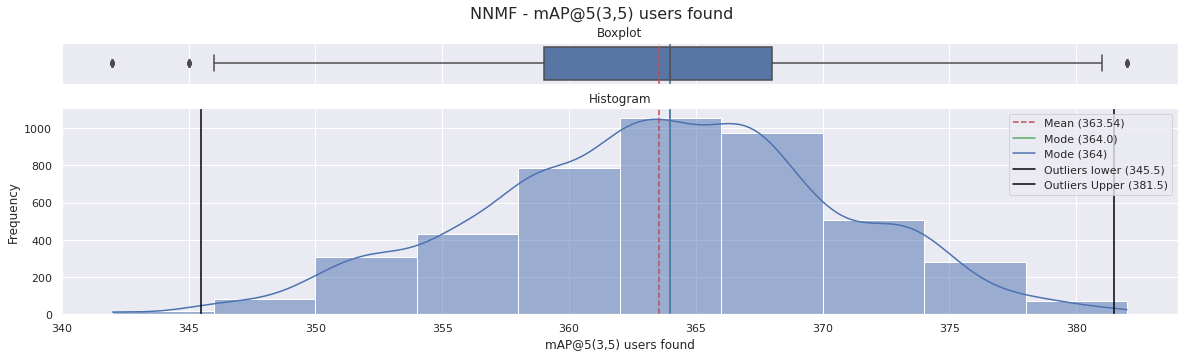


Metrics:



,"mAP@5(3,5) users found"
count,4500.000000
mean,363.540000
std,6.926403
min,342.000000
25%,359.000000
50%,364.000000
75%,368.000000
max,382.000000


<Figure size 1440x360 with 2 Axes>

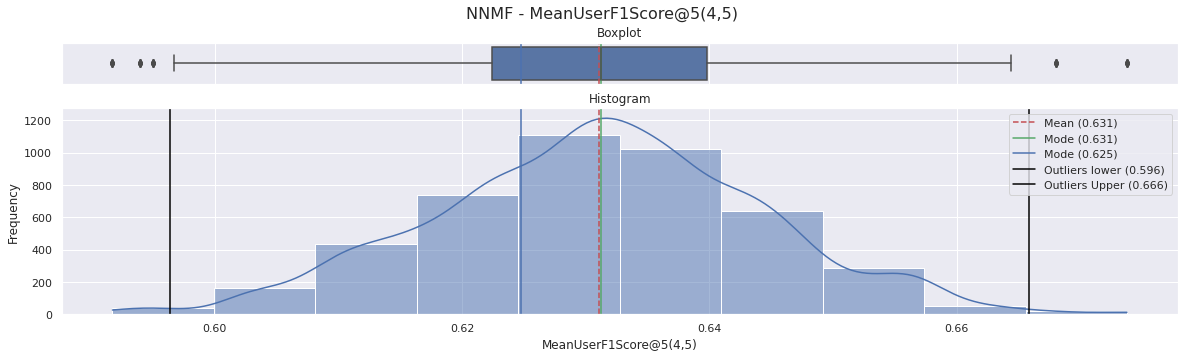


Metrics:



,"MeanUserF1Score@5(4,5)"
count,4500.000000
mean,0.631042
std,0.013246
min,0.591713
25%,0.622403
50%,0.631206
75%,0.639780
max,0.673771


<Figure size 1440x360 with 2 Axes>

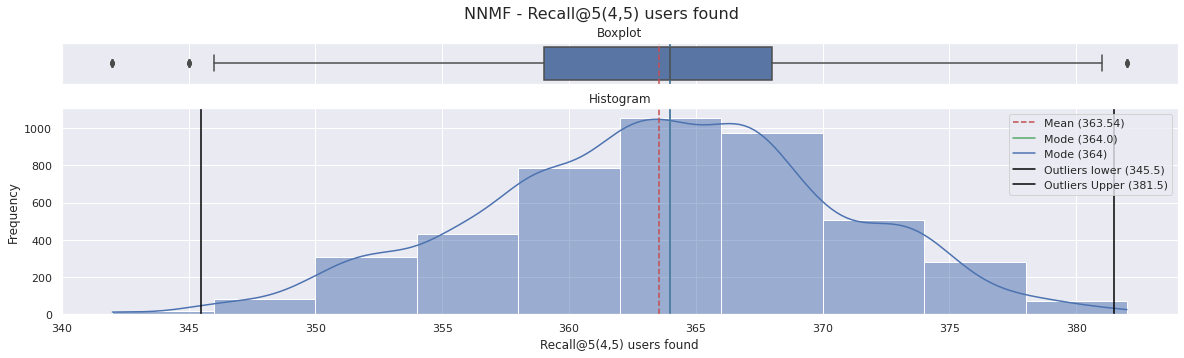


Metrics:



,"Recall@5(4,5) users found"
count,4500.000000
mean,363.540000
std,6.926403
min,342.000000
25%,359.000000
50%,364.000000
75%,368.000000
max,382.000000


<Figure size 1440x360 with 2 Axes>

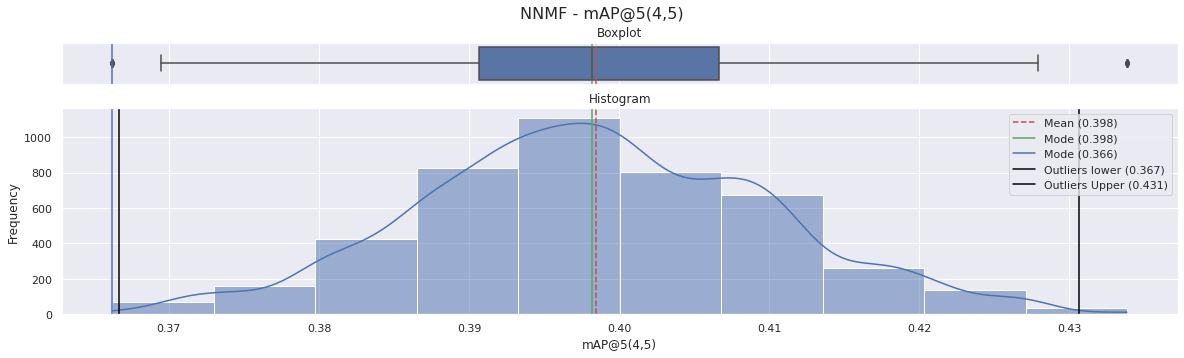


Metrics:



,"mAP@5(4,5)"
count,4500.000000
mean,0.398433
std,0.011674
min,0.366237
25%,0.390669
50%,0.398186
75%,0.406653
max,0.433838


<Figure size 1440x360 with 2 Axes>

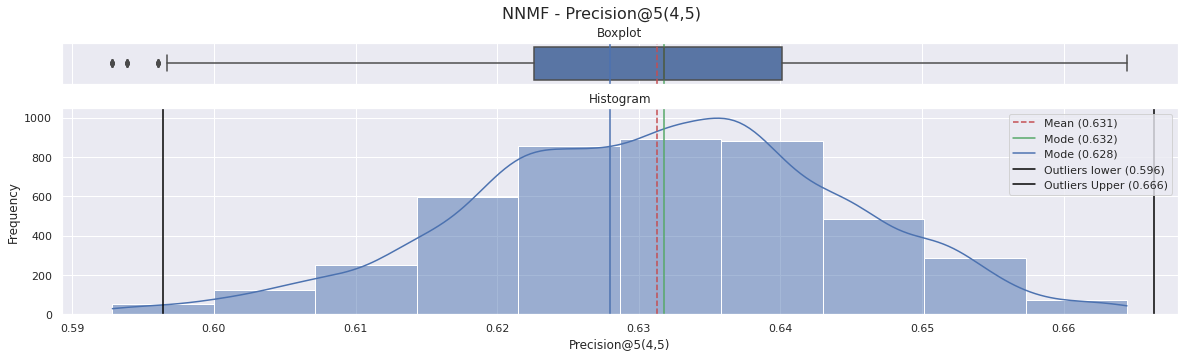


Metrics:



,"Precision@5(4,5)"
count,4500.000000
mean,0.631310
std,0.013003
min,0.592838
25%,0.622621
50%,0.631786
75%,0.640110
max,0.664463


<Figure size 1440x360 with 2 Axes>

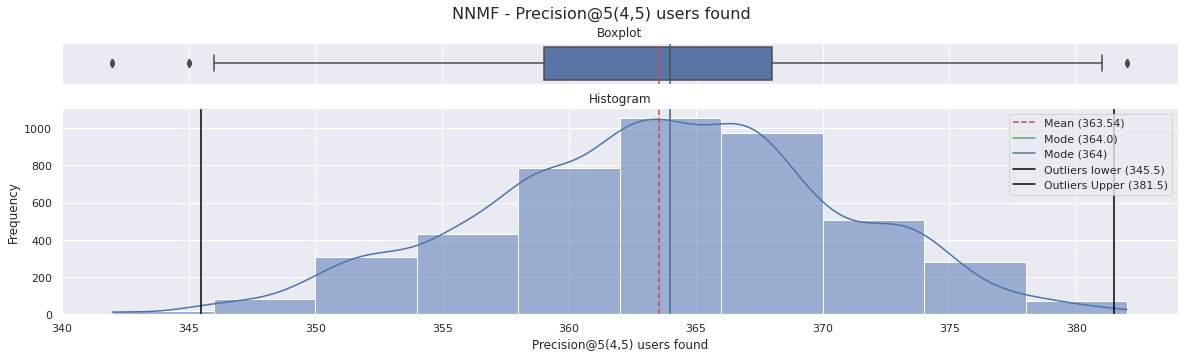


Metrics:



,"Precision@5(4,5) users found"
count,4500.000000
mean,363.540000
std,6.926403
min,342.000000
25%,359.000000
50%,364.000000
75%,368.000000
max,382.000000


<Figure size 1440x360 with 2 Axes>

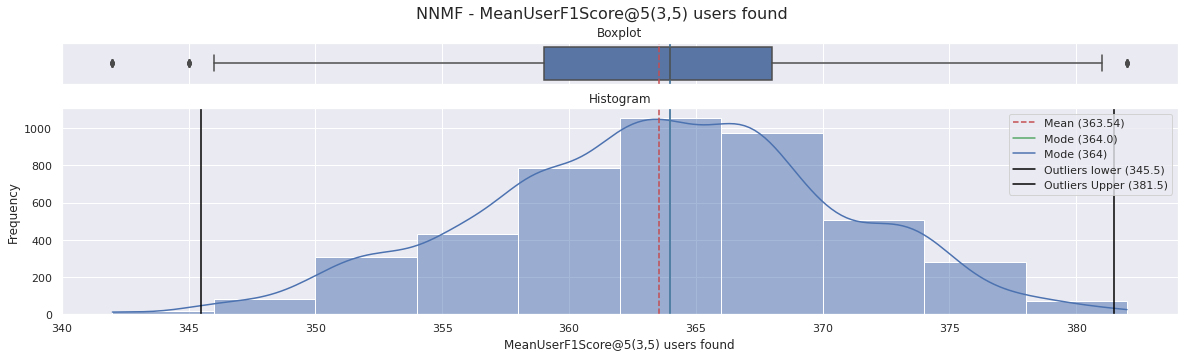


Metrics:



,"MeanUserF1Score@5(3,5) users found"
count,4500.000000
mean,363.540000
std,6.926403
min,342.000000
25%,359.000000
50%,364.000000
75%,368.000000
max,382.000000


<Figure size 1440x360 with 2 Axes>

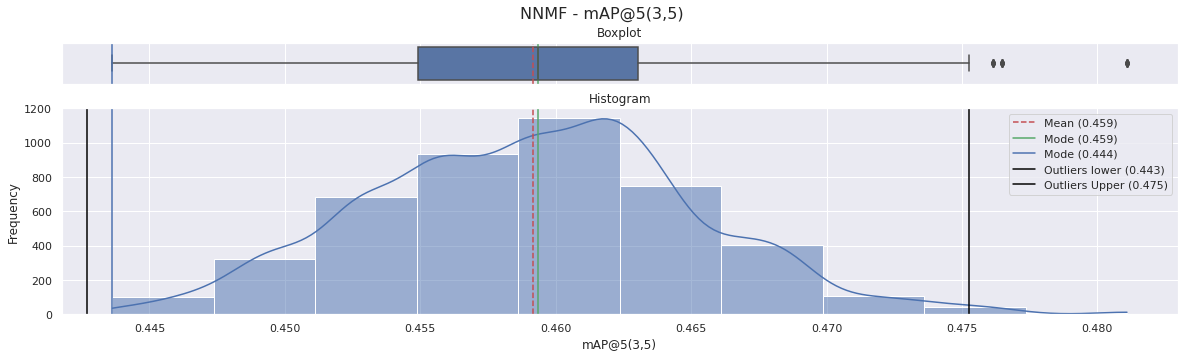


Metrics:



,"mAP@5(3,5)"
count,4500.000000
mean,0.459156
std,0.006055
min,0.443632
25%,0.454910
50%,0.459328
75%,0.463055
max,0.481092


<Figure size 1440x360 with 2 Axes>

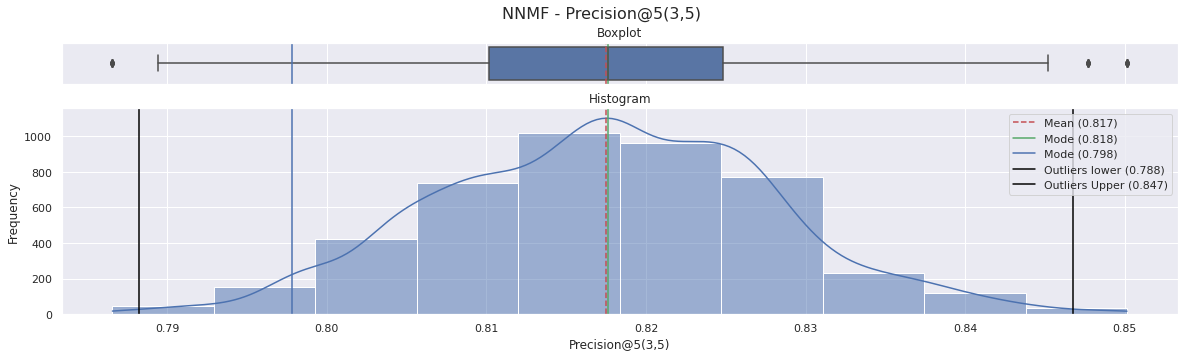


Metrics:



,"Precision@5(3,5)"
count,4500.000000
mean,0.817499
std,0.010519
min,0.786559
25%,0.810175
50%,0.817630
75%,0.824813
max,0.850139


<Figure size 1440x360 with 2 Axes>

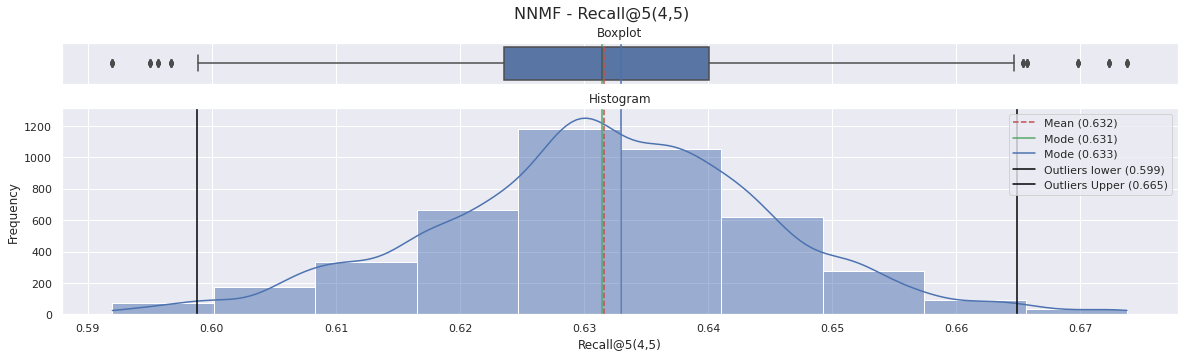


Metrics:



,"Recall@5(4,5)"
count,4500.000000
mean,0.631646
std,0.013431
min,0.591979
25%,0.623585
50%,0.631479
75%,0.640110
max,0.673770


<Figure size 1440x360 with 2 Axes>

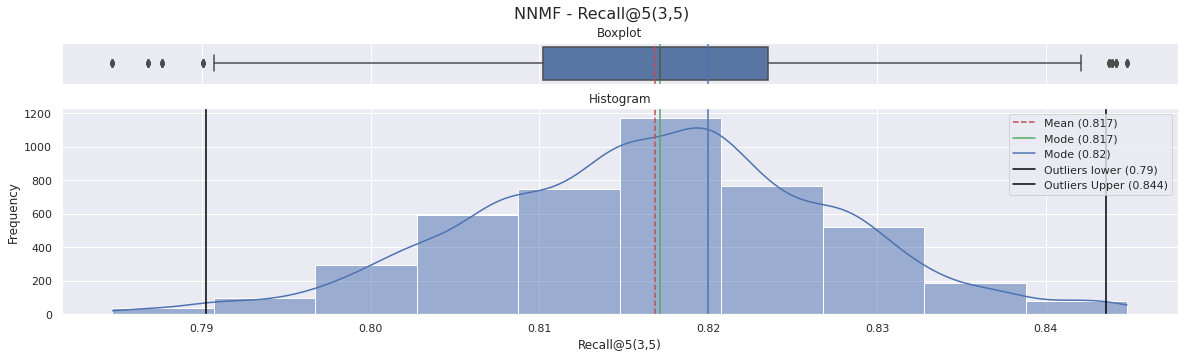


Metrics:



,"Recall@5(3,5)"
count,4500.000000
mean,0.816833
std,0.010513
min,0.784699
25%,0.810231
50%,0.817127
75%,0.823554
max,0.844809


<Figure size 1440x360 with 2 Axes>

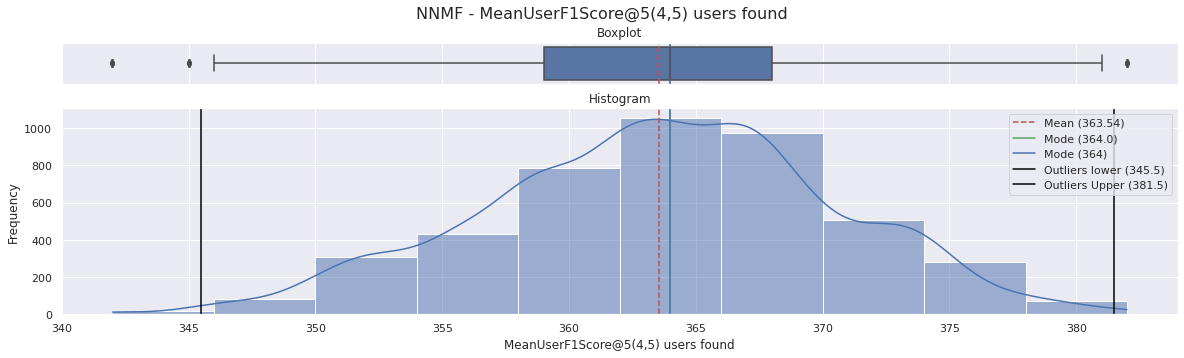


Metrics:



,"MeanUserF1Score@5(4,5) users found"
count,4500.000000
mean,363.540000
std,6.926403
min,342.000000
25%,359.000000
50%,364.000000
75%,368.000000
max,382.000000


<Figure size 1440x360 with 2 Axes>

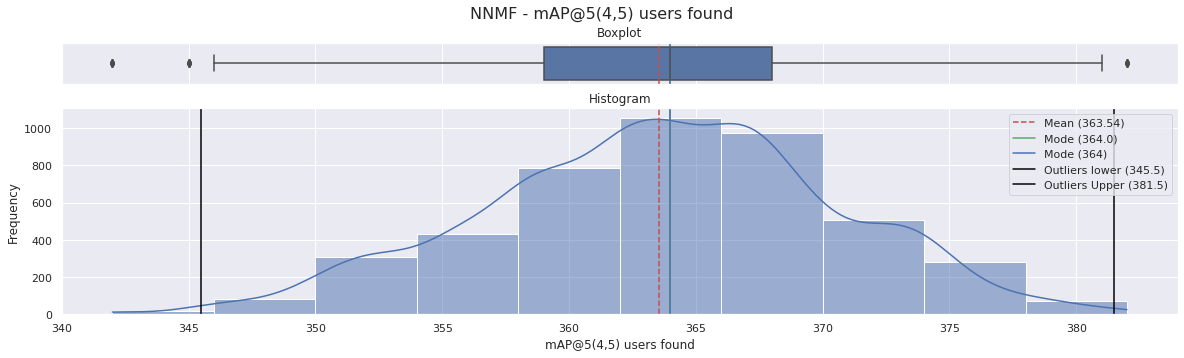


Metrics:



,"mAP@5(4,5) users found"
count,4500.000000
mean,363.540000
std,6.926403
min,342.000000
25%,359.000000
50%,364.000000
75%,368.000000
max,382.000000


<Figure size 1440x360 with 2 Axes>

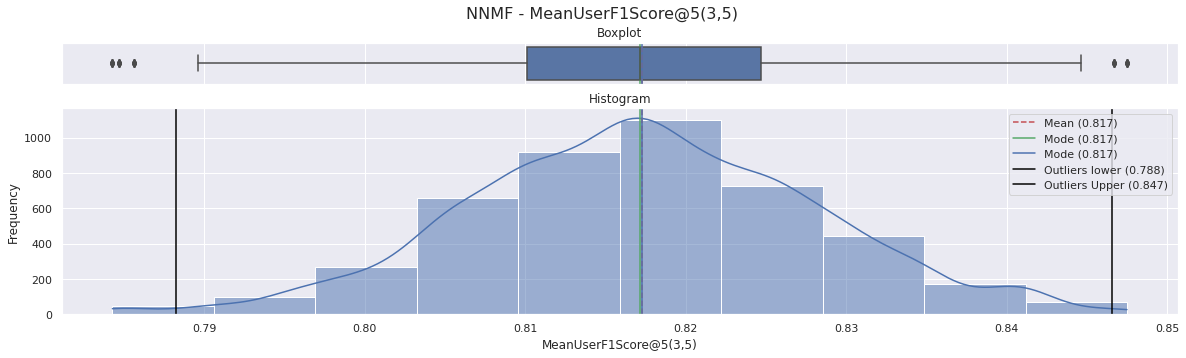


Metrics:



,"MeanUserF1Score@5(3,5)"
count,4500.000000
mean,0.817292
std,0.010859
min,0.784270
25%,0.810087
50%,0.817143
75%,0.824673
max,0.847486


<Figure size 1440x360 with 2 Axes>

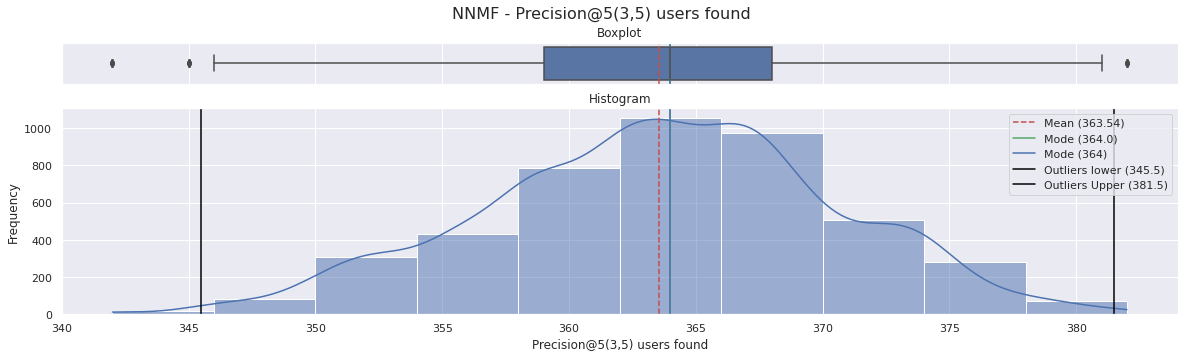


Metrics:



,"Precision@5(3,5) users found"
count,4500.000000
mean,363.540000
std,6.926403
min,342.000000
25%,359.000000
50%,364.000000
75%,368.000000
max,382.000000


<Figure size 1440x360 with 2 Axes>

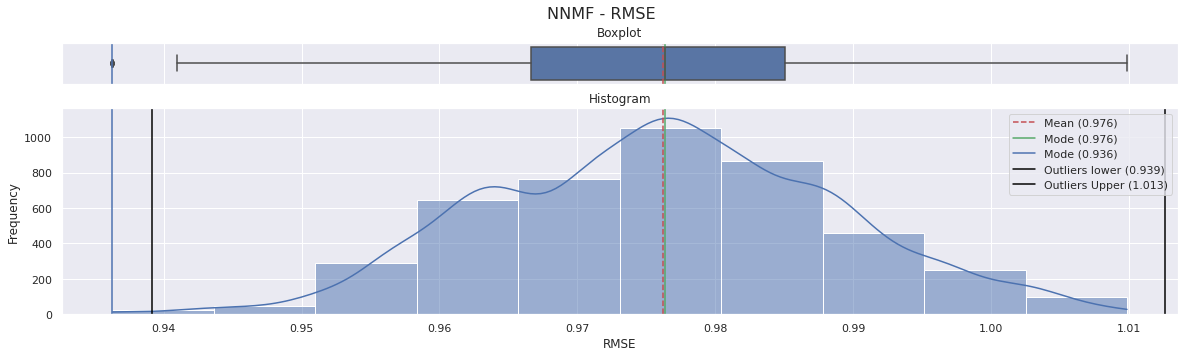


Metrics:



,RMSE
count,4500.000000
mean,0.976195
std,0.012618
min,0.936276
25%,0.966674
50%,0.976330
75%,0.985047
max,1.009877


<Figure size 1440x360 with 2 Axes>

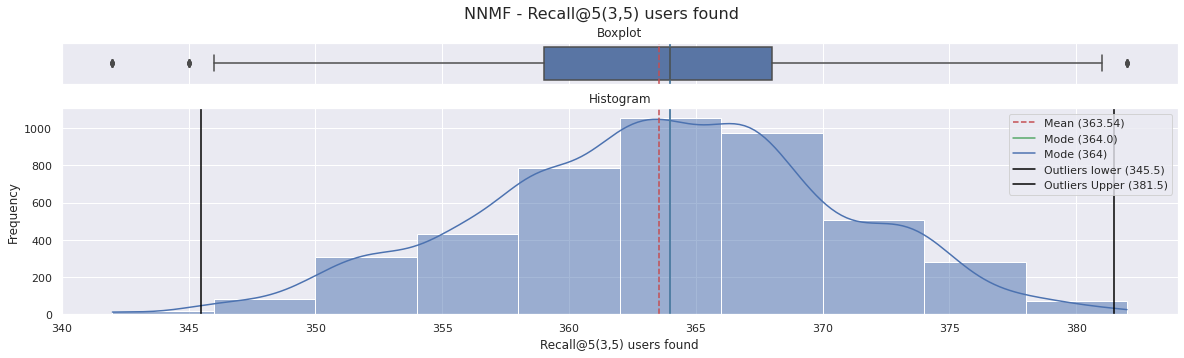


Metrics:



,"Recall@5(3,5) users found"
count,4500.000000
mean,363.540000
std,6.926403
min,342.000000
25%,359.000000
50%,364.000000
75%,368.000000
max,382.000000


In [16]:
PATH = '../weights/2022-07-23_16-59-25--nnmf--epoch_46--val_loss_0.8593634963035583.pt'
model.load_state_dict(torch.load(PATH))

deep_fm_predictor = ml.ModulePredictor(model)

validator = ml.Validator(
    n_samples  = 500,
    batch_size = 10000,
    metrics    = [
        mt.RMSE(),

        mt.MeanAveragePrecisionAtk(user_index=0, k=5, discretizer=dr.between(4, 5)),
        mt.MeanUserFBetaScoreAtk(user_index=0, k=5, discretizer=dr.between(4, 5)),
        mt.MeanUserPrecisionAtk(user_index=0, k=5, discretizer=dr.between(4, 5)),
        mt.MeanUserRecallAtk(user_index=0, k=5, discretizer=dr.between(4, 5)),
        
        mt.MeanAveragePrecisionAtk(user_index=0, k=5, discretizer=dr.between(3, 5)),
        mt.MeanUserFBetaScoreAtk(user_index=0, k=5, discretizer=dr.between(3, 5)),
        mt.MeanUserPrecisionAtk(user_index=0, k=5, discretizer=dr.between(3, 5)),
        mt.MeanUserRecallAtk(user_index=0, k=5, discretizer=dr.between(3, 5))
    ],
    predictors = [deep_fm_predictor]
)

summary = validator.validate(eval_set)

summary.save('../metrics/nnmf')


summary = ml.ValidatorSummary.load('../metrics/nnmf')
summary.plot(bins=10, show_table=True)